# HW_06 Бондаренко Алексей (bondaleksey@gmail.com)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import timedelta

from sklearn.model_selection import cross_val_score
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Цель проекта 
Цель проекта: построить модель, которая способна прогнозировать загрузку метро на ближайшее время (2 недели)

План выполнения работы:
- Базовый EDA
- Генерация дополнительных признаков
- Baseline прогноз и проверка качества
- Построение различных моделей

# 1 Данные

## 1.1 Описание данных
 Признаки [набора данных](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

 - holiday (Categorical) -  US National holidays plus regional holiday, Minnesota State Fair
 - temp (Numeric) -  Average temp in kelvin
 - rain_1h (Numeric) -  Amount in mm of rain that occurred in the hour
 - snow_1h (Numeric) - Amount in mm of snow that occurred in the hour
 - clouds_all (Numeric) - Percentage of cloud cover
 - weather_main (Categorical) - Short textual description of the current weather
 - weather_description (Categorical) - Longer textual description of the current weather
 - date_time (DateTime) - Hour of the data collected in local CST time
 - traffic_volume (Numeric) - Hourly I-94 ATR 301 reported westbound traffic volume

In [2]:
data = pd.read_csv('data_ts/archive.csv.gz',compression='gzip', header=0, sep=',', quotechar='"',index_col=0)                  

In [3]:
data.head(5)

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
holiday,,,,,,,,
None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data = data.reset_index();

## 1.2 Разведывательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [6]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [7]:
def EDA(data):
    cols = data.columns
    print('Printing figures for columns:\n',cols)
    for item in cols:
        if item=='date_time':
            continue
        print("Look at column:", item)
        dt = data[item].dtype          
        if dt == 'int64'or dt == 'float64':        
            ax = data[item].plot(kind = 'hist', bins = 50)
            ax.set_xlabel(item)
            plt.show()
        elif dt == 'object':
            ax = data[item].value_counts().plot(kind = 'bar')
            ax.set_xlabel(item)
            plt.show()
        else:
            print(f'ooops, have problems with {item}')

Printing figures for columns:
 Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')
Look at column: holiday


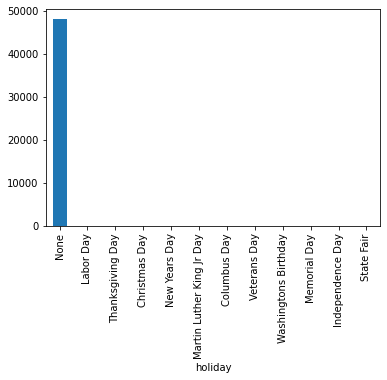

Look at column: temp


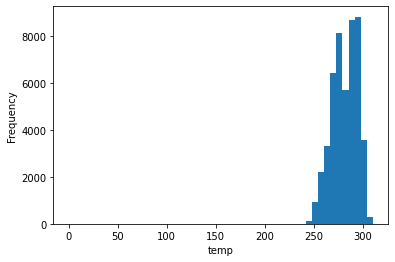

Look at column: rain_1h


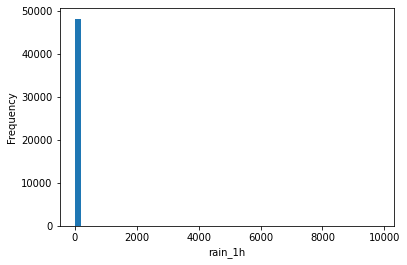

Look at column: snow_1h


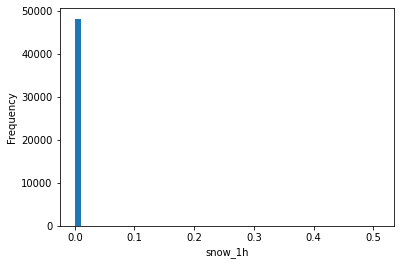

Look at column: clouds_all


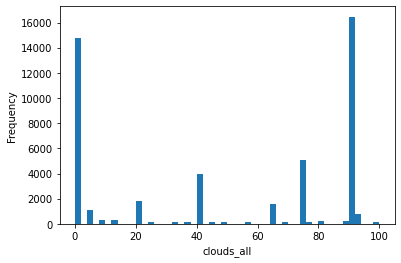

Look at column: weather_main


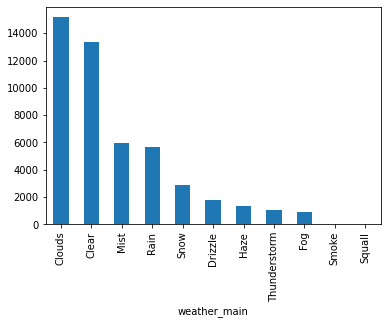

Look at column: weather_description


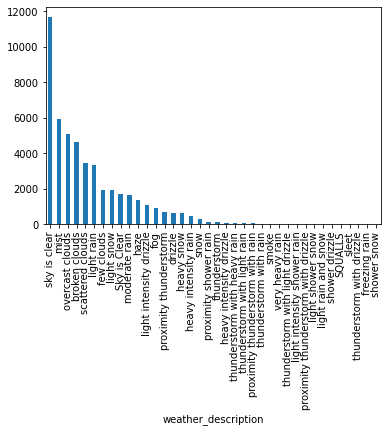

Look at column: traffic_volume


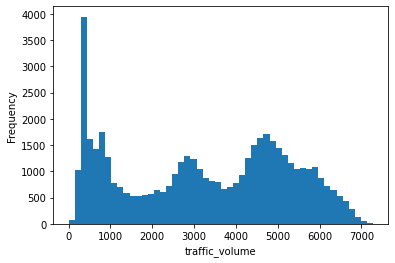

In [8]:
EDA(data)

 ## 1.3 Преобразование данных и выбор признаков

### 1.3.1 Убираем дубликаты 

In [9]:
data.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [10]:
wdata = data[['date_time','holiday','temp','traffic_volume']].copy()
wdata['date_time'] = pd.to_datetime(wdata['date_time'])
wdata = wdata.set_index('date_time')
wdata = wdata.drop_duplicates()

In [11]:
wdata.head()

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545
2012-10-02 10:00:00,None,289.36,4516
2012-10-02 11:00:00,None,289.58,4767
2012-10-02 12:00:00,None,290.13,5026
2012-10-02 13:00:00,None,291.14,4918


In [12]:
wdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40606 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40606 non-null  object 
 1   temp            40606 non-null  float64
 2   traffic_volume  40606 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


In [13]:
40606/(24*365)

4.635388127853881

 А в информации данных указано, что период времени в данных почти 6 лет. Значит отсутствует значительная часть в данных.

### 1.3.2 Добавляем пропуски в записи данных по времени 

In [14]:
print(wdata.loc['2012-11-05 13:00:00':'2012-11-05 21:00:00'])

                    holiday    temp  traffic_volume
date_time                                          
2012-11-05 13:00:00    None  278.47            4648
2012-11-05 14:00:00    None  278.71            4968
2012-11-05 16:00:00    None  280.56            6124
2012-11-05 17:00:00    None  280.56            6134
2012-11-05 18:00:00    None  279.26            4265
2012-11-05 20:00:00    None  280.56            2415
2012-11-05 21:00:00    None  280.56            1963


Как мы видим отсутствуют значения для 15 и 19 часов.

In [15]:
right_dates = pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')
len(right_dates)

52551

Создадим пустой датафрейм с правильной индексацией по времени и потом объединим его с предварительно обработанными данными.

In [16]:
my_df = pd.DataFrame({'date_time': right_dates}).set_index('date_time')
my_df.head(3)

""
date_time
2012-10-02 09:00:00
2012-10-02 10:00:00
2012-10-02 11:00:00


In [17]:
clean_data = my_df.join(wdata)
clean_data.head(3)

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545.0
2012-10-02 10:00:00,None,289.36,4516.0
2012-10-02 11:00:00,None,289.58,4767.0


In [18]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52629 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40606 non-null  object 
 1   temp            40606 non-null  float64
 2   traffic_volume  40606 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


Число строчек в полученном DataFrame 52629, а число дат в нужном диапазоне = 52551.

In [19]:
(629-551)

78

### 1.3.3 Исправляем двойные значения в данных температуры

In [20]:
dupl = clean_data.index.duplicated(keep='last')
dupl.sum()

78

In [21]:
clean_data[clean_data.index.duplicated(keep=False)].head(6)

,holiday,temp,traffic_volume
date_time,,,
2012-11-04 01:00:00,None,275.60,730.0
2012-11-04 01:00:00,None,275.77,730.0
2014-01-03 20:00:00,None,267.97,2427.0
2014-01-03 20:00:00,None,268.88,2427.0
2014-01-09 16:00:00,None,265.73,6421.0
2014-01-09 16:00:00,None,266.47,6421.0


In [22]:
working_data = clean_data[~dupl].copy()

In [23]:
working_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            40528 non-null  float64
 2   traffic_volume  40528 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


In [24]:
month_number = list(map(lambda x: (x.month),right_dates))
is_weekend = list(map(lambda x: int((x.dayofweek>4)),right_dates))

In [25]:
working_data['is_holiday'] = working_data[working_data['holiday'].notna()]['holiday'].apply(lambda x: 0 if x == 'None' else 1)

In [26]:
# clean_data['is_weekend'] = pd.Series(is_weekend).values
working_data['is_weekend'] = is_weekend
working_data['month_number'] = month_number

In [27]:
working_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            40528 non-null  float64
 2   traffic_volume  40528 non-null  float64
 3   is_holiday      40528 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ MB


In [28]:
in_data = working_data.interpolate(method='linear', axis=0).copy()

In [29]:
in_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
 3   is_holiday      52551 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ MB


In [30]:
in_data.describe()

,temp,traffic_volume,is_holiday,is_weekend,month_number
count,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000
mean,282.501583,3071.897557,0.001056,0.285894,6.521779
std,12.993132,1922.467889,0.032113,0.451843,3.448434
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,273.580000,1223.599161,0.000000,0.000000,4.000000
50%,286.420000,2897.000000,0.000000,0.000000,7.000000
75%,291.703441,4775.000000,0.000000,1.000000,10.000000
max,310.070000,7280.000000,1.000000,1.000000,12.000000


In [31]:
in_data.loc['2013-10-13 22:00:00':'2013-10-14 05:00:00'].head(20)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number
date_time,,,,,,
2013-10-13 22:00:00,NaN,279.835714,1693.857143,0.0,1,10
2013-10-13 23:00:00,None,278.580000,1084.000000,0.0,1,10
2013-10-14 00:00:00,Columbus Day,277.720000,615.000000,1.0,0,10
2013-10-14 01:00:00,NaN,277.395000,453.000000,0.5,0,10
2013-10-14 02:00:00,None,277.070000,291.000000,0.0,0,10
2013-10-14 03:00:00,None,276.700000,388.000000,0.0,0,10
2013-10-14 04:00:00,NaN,277.145000,1541.000000,0.0,0,10
2013-10-14 05:00:00,None,277.590000,2694.000000,0.0,0,10


In [32]:
in_data['was_nan'] = working_data['traffic_volume'].isnull().astype(int)
in_data.head()

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2012-10-02 09:00:00,None,288.28,5545.0,0.0,0,10,0
2012-10-02 10:00:00,None,289.36,4516.0,0.0,0,10,0
2012-10-02 11:00:00,None,289.58,4767.0,0.0,0,10,0
2012-10-02 12:00:00,None,290.13,5026.0,0.0,0,10,0
2012-10-02 13:00:00,None,291.14,4918.0,0.0,0,10,0


In [33]:
in_data[in_data['is_holiday']==1].head(20)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2012-10-08,Columbus Day,273.08,455.0,1.0,0,10,0
2012-11-12,Veterans Day,288.12,1000.0,1.0,0,11,0
2012-11-22,Thanksgiving Day,278.54,919.0,1.0,0,11,0
2012-12-25,Christmas Day,264.40,803.0,1.0,0,12,0
2013-01-01,New Years Day,263.49,1439.0,1.0,0,1,0
2013-02-18,Washingtons Birthday,258.96,556.0,1.0,0,2,0
2013-05-27,Memorial Day,286.37,863.0,1.0,0,5,0
2013-07-04,Independence Day,290.08,1060.0,1.0,0,7,0
2013-08-22,State Fair,297.42,661.0,1.0,0,8,0


### Неожиданности 
Если посмотреть на даты праздничных дней, то видно что в некоторые годы праздничных дней значительно меньше, в 14 году всего 4 праздника и нет Рождества ... 

Так как в дата сете есть целые пропущенные дни, то возможно надо либо эти прощенные данные выкинуть, а оставшиеся использовать, либо пометить их как-то. Но ключевой вопрос, сколько у тебя интервалов прощенных данных и какова была их длинна? 


In [34]:
pd.unique(working_data['holiday'])

array(['None', nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [35]:
def add_holidays(df):
       holidays = ['Columbus Day', 'Veterans Day', 'Thanksgiving Day',
                   'Christmas Day', 'New Years Day', 'Washingtons Birthday',
                   'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
                   'Martin Luther King Jr Day']
       out = df[df['holiday'].isin(holidays)]
       delta_hour = timedelta(hours=1)
       for day in out.index:
              for i in range(1,24,1):
                     df.loc[day+delta_hour*i,'is_holiday'] = 1       
       

In [36]:
add_holidays(in_data)

In [37]:
in_data['is_holiday'].sum()

1273.0

In [38]:
in_data.loc['2013-10-13 22:00:00':'2013-10-15 03:00:00'].head(50)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2013-10-13 22:00:00,NaN,279.835714,1693.857143,0.0,1,10,1
2013-10-13 23:00:00,None,278.580000,1084.000000,0.0,1,10,0
2013-10-14 00:00:00,Columbus Day,277.720000,615.000000,1.0,0,10,0
2013-10-14 01:00:00,NaN,277.395000,453.000000,1.0,0,10,1
2013-10-14 02:00:00,None,277.070000,291.000000,1.0,0,10,0
2013-10-14 03:00:00,None,276.700000,388.000000,1.0,0,10,0
2013-10-14 04:00:00,NaN,277.145000,1541.000000,1.0,0,10,1
2013-10-14 05:00:00,None,277.590000,2694.000000,1.0,0,10,0
2013-10-14 06:00:00,None,277.990000,5729.000000,1.0,0,10,0


In [39]:
in_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
 3   is_holiday      52551 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
 6   was_nan         52551 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 5.0+ MB


In [40]:
in_data.describe()

,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
count,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000
mean,282.501583,3071.897557,0.024224,0.285894,6.521779,0.228787
std,12.993132,1922.467889,0.153715,0.451843,3.448434,0.420056
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,273.580000,1223.599161,0.000000,0.000000,4.000000,0.000000
50%,286.420000,2897.000000,0.000000,0.000000,7.000000,0.000000
75%,291.703441,4775.000000,0.000000,1.000000,10.000000,0.000000
max,310.070000,7280.000000,1.000000,1.000000,12.000000,1.000000


In [41]:
print(pd.unique(in_data['is_holiday']))

[0.  1.  0.5]


In [42]:
in_data.loc[in_data[in_data['is_holiday']==0.5].index,'is_holiday']=0

### 1.3.4 Рассмотрим длины интервалов отсутствующих данных

In [43]:
def NAN_analysis(df):
    out_nans = {}
    delta_hour = timedelta(hours=1)
    out_data = df[df['traffic_volume'].isnull()].copy()
    out_data = out_data.reset_index()
    out_data['shifted'] = out_data['date_time'].shift(-1)  
    # print(out_data.head(10))
    start_nans = out_data.iloc[0,0]
    end_nans = None
    count_nans = 1
    for ind, row in out_data.iterrows():
        if row['shifted']-row['date_time'] > delta_hour:
            end_nans = row['date_time']
            out_nans[start_nans] = (count_nans,end_nans) 
            count_nans = 1
            start_nans = row['shifted']
            end_nans = None
        else:
            count_nans+=1
    return out_data, out_nans
    

In [44]:
out_data_all, out_nans_all = NAN_analysis(working_data)
out_data_all.head(5)

,date_time,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,shifted
0,2012-10-03 07:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-03 10:00:00
1,2012-10-03 10:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-03 11:00:00
2,2012-10-03 11:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-03 17:00:00
3,2012-10-03 17:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-05 02:00:00
4,2012-10-05 02:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-05 04:00:00


In [45]:
for k,val in out_nans_all.items():
    if val[0] > 24:# and val[0]< 26:
    # stime = '2015-10-27 23:00:00'
    # dtime = (datetime.strptime(stime,"%Y-%m-%d %H:%M:%S"))                                        #  "%Y-%m-%d %H:%M:%S").timetuple()))
    # if k>dtime:        
        print(f'number of NAN points: {val[0]}, beg: {k}, end: {val[1]}') 

number of NAN points: 46, beg: 2013-08-31 01:00:00, end: 2013-09-01 22:00:00
number of NAN points: 29, beg: 2013-09-03 03:00:00, end: 2013-09-04 07:00:00
number of NAN points: 242, beg: 2013-10-27 02:00:00, end: 2013-11-06 03:00:00
number of NAN points: 116, beg: 2014-04-29 09:00:00, end: 2014-05-04 04:00:00
number of NAN points: 64, beg: 2014-07-27 17:00:00, end: 2014-07-30 08:00:00
number of NAN points: 32, beg: 2014-08-02 03:00:00, end: 2014-08-03 10:00:00
number of NAN points: 7386, beg: 2014-08-08 02:00:00, end: 2015-06-11 19:00:00
number of NAN points: 117, beg: 2015-06-14 21:00:00, end: 2015-06-19 17:00:00
number of NAN points: 29, beg: 2015-06-20 19:00:00, end: 2015-06-21 23:00:00
number of NAN points: 33, beg: 2015-06-22 19:00:00, end: 2015-06-24 03:00:00
number of NAN points: 92, beg: 2015-10-23 12:00:00, end: 2015-10-27 07:00:00


### 1.3.5 В заключении о пропусках в данных  
Последний значительный интервал с отсутствующими данными, превышающими 1 день (24 временные точки), произошел 23 октября 2015 года. 

Number of NAN points: 92, beg: 2015-10-23 12:00:00, end: 2015-10-27 07:00:00

Далее будем рассматривать данные датируемые после 2015-10-27 7:00:00, так как после этой даты в датасете присутствуют не значительные (не более 10 временных точек) пропуски. 

In [46]:
in_data.tail()

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2018-09-30 19:00:00,None,283.45,3543.0,0.0,1,9,0
2018-09-30 20:00:00,None,282.76,2781.0,0.0,1,9,0
2018-09-30 21:00:00,None,282.73,2159.0,0.0,1,9,0
2018-09-30 22:00:00,None,282.09,1450.0,0.0,1,9,0
2018-09-30 23:00:00,None,282.12,954.0,0.0,1,9,0


In [47]:
short_data = in_data[in_data.index>'2015-10-27 23:00:00'].copy()
# short_data.drop(['holiday','is_weekday','month_number'],axis=1,inplace=True)
short_data.drop(['holiday','month_number'],axis=1,inplace=True)
# short_data.drop(['is_weekday'],axis=1,inplace=True)

In [48]:
short_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25656 entries, 2015-10-28 00:00:00 to 2018-09-30 23:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            25656 non-null  float64
 1   traffic_volume  25656 non-null  float64
 2   is_holiday      25656 non-null  float64
 3   is_weekend      25656 non-null  int64  
 4   was_nan         25656 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.1 MB


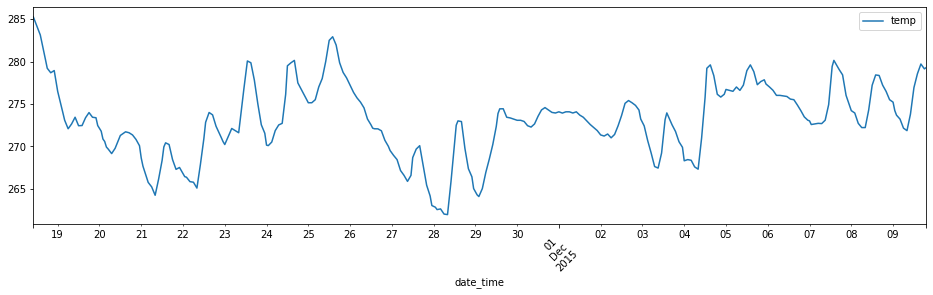

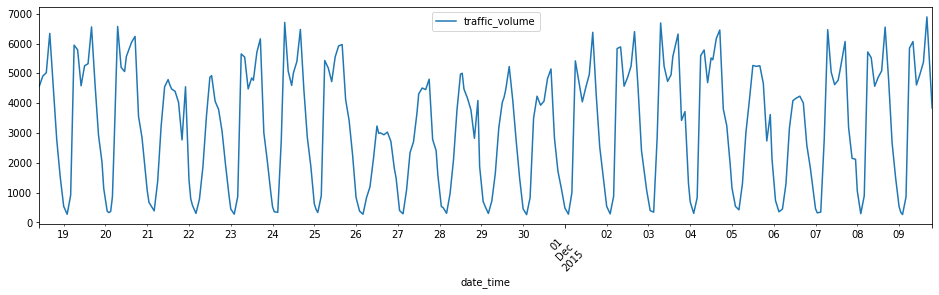

 h = 514, a = 514, b = 1028


In [49]:
def plot_data(df):
    N = 50
    h = int(np.ceil(len(df.index)/N))    
    # for i in range(N-1):
    a = h
    b = 2*h
 
    df.iloc[a:b,0].plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    df.iloc[a:b,1].plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    print(f" h = {h}, a = {a}, b = {b}")

plot_data(short_data)

# 2 Моделирование без временных признаков 

In [50]:
def create_lags(df, series_columns, start_lag, end_lag):
    data = df.copy()
    for c in series_columns:
        for i in range(start_lag, end_lag):
            data["lag_{}_{}".format(c, i)] = data[c].shift(i)
    return data


def timeseries_train_test_split(y, X=None, test_size=0.2, stime = None):
    """
    Performs train-test split with respect to time series structure
    :param X:         x data
    :type X:           pd.DataFrame
    :param y:         y data
    :type y:           pd.Series
    :param test_size: percent of test data from the end of series (0-1)
    :type test_size:   float
    """
    two_weeks = 7*2*24
    if len(y) < 2*two_weeks:
        train_index = int(len(y)*(1-test_size))
    else:        
        train_index = len(y) - two_weeks 
    
    if X is None:
        y_train = y.iloc[:train_index]
        y_test = y.iloc[train_index:]
        return y_train, y_test
    else:
        X_train = X.iloc[:train_index]
        y_train = y.iloc[:train_index]
        X_test = X.iloc[train_index:]
        y_test = y.iloc[train_index:]
        return X_train, X_test, y_train, y_test

In [51]:
dtest = short_data.iloc[:200]

In [52]:
short_data.head()

,temp,traffic_volume,is_holiday,is_weekend,was_nan
date_time,,,,,
2015-10-28 00:00:00,281.430000,507.000000,0.0,0,0
2015-10-28 01:00:00,281.430000,339.000000,0.0,0,0
2015-10-28 02:00:00,281.383333,529.333333,0.0,0,1
2015-10-28 03:00:00,281.336667,719.666667,0.0,0,1
2015-10-28 04:00:00,281.290000,910.000000,0.0,0,0


In [53]:
short_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25656 entries, 2015-10-28 00:00:00 to 2018-09-30 23:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            25656 non-null  float64
 1   traffic_volume  25656 non-null  float64
 2   is_holiday      25656 non-null  float64
 3   is_weekend      25656 non-null  int64  
 4   was_nan         25656 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.1 MB


In [54]:
scaler = MinMaxScaler()
short_data.columns 

Index(['temp', 'traffic_volume', 'is_holiday', 'is_weekend', 'was_nan'], dtype='object')

In [55]:
scale_cols = ['temp']
short_data.loc[:,scale_cols].head()

,temp
date_time,
2015-10-28 00:00:00,281.430000
2015-10-28 01:00:00,281.430000
2015-10-28 02:00:00,281.383333
2015-10-28 03:00:00,281.336667
2015-10-28 04:00:00,281.290000


In [56]:
scaler.fit(short_data.loc[:,scale_cols])
print(scaler.data_max_)
print(scaler.data_min_)

[310.07]
[243.39]


In [57]:
short_data.loc[:,scale_cols] = scaler.transform(short_data.loc[:,scale_cols])
short_data.loc[:,scale_cols].head()

,temp
date_time,
2015-10-28 00:00:00,0.570486
2015-10-28 01:00:00,0.570486
2015-10-28 02:00:00,0.569786
2015-10-28 03:00:00,0.569086
2015-10-28 04:00:00,0.568386


In [58]:
data = create_lags(df=short_data[:5000], series_columns=["traffic_volume"], start_lag=1, end_lag=60)
col_lag = 6
results = []
y = data.dropna()["traffic_volume"]
X = data.dropna().drop(["traffic_volume"], axis=1)
# X.iloc[:,col_lag:] = scaler.fit_transform(X.iloc[:,col_lag:])


X_train, X_test, y_train, y_test = timeseries_train_test_split(y, X, test_size=0.1, stime=None)

In [59]:
def plotModelResults(model,model_name, X_train, y_train, X_test, y_test,
                     plot_train=False, plot_intervals=False, plot_anomalies=False):
    """
    Plots modelled vs fact values, prediction intervals and anomalies
    """
    tscv = TimeSeriesSplit(n_splits=5)
    prediction = model.predict(X_test)
    
    N_train = len(y_train)
    N_test = len(y_test)
    train_index = range(N_train)
    test_index = range(N_train, N_train+N_test)
    
    plt.figure(figsize=(15, 7))
    if plot_train:
        plt.plot(train_index, y_train.values, label="train actual")
    plt.plot(test_index, y_test.values, label="actual", linewidth=2.0)
    plt.plot(test_index, prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(test_index, lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(test_index, upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(test_index, anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(y_test,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)    
    errors={model_name:{
        "Mean absolute percentage error":error,
        "Mean absolute error":mean_absolute_error(y_test,prediction),
        "Mean squared error":mean_squared_error(y_test,prediction,squared=True),
        "Root mean squared error":mean_squared_error(y_test,prediction,squared=False),
        "R2": r2_score(y_test,prediction)
        }}
    return errors
    

In [60]:
lr = LinearRegression() 
lr.fit(X_train, y_train)

LinearRegression()

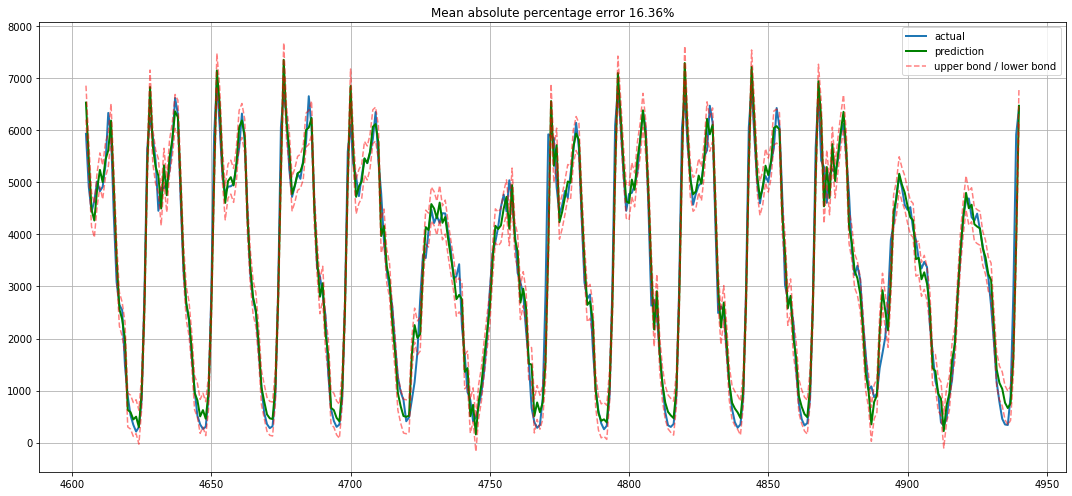

In [61]:
er = plotModelResults(lr, 'Cheating Linear Regression without time features', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_intervals=True)
results.append(er)

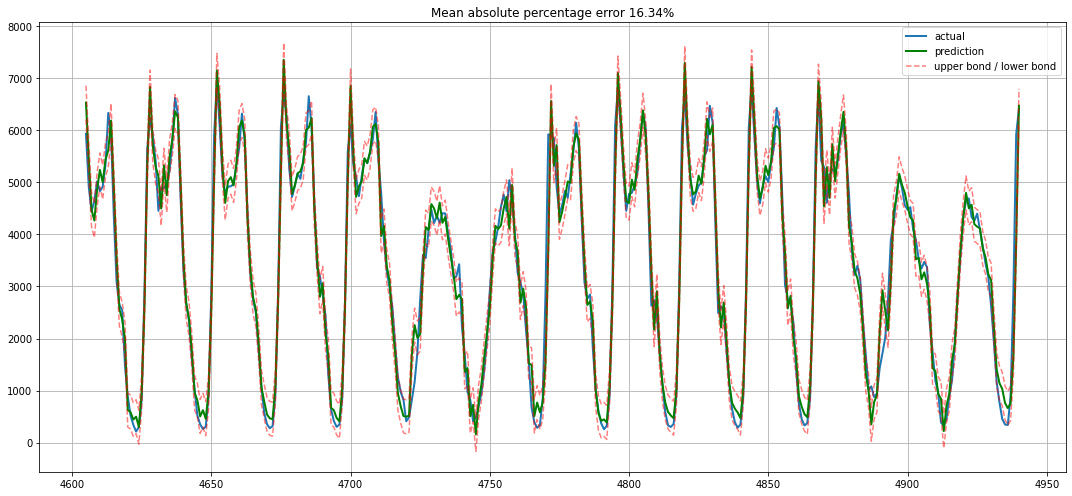

In [62]:
ridge = Ridge(random_state=4973)
ridge.fit(X_train, y_train)
er = plotModelResults(ridge, 'Cheating Ridge without time features',X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_intervals=True)
results.append(er)

In [63]:
def recursive_predict(model, df_forecast,col_lags = 0):
    horizon = len(df_forecast)
    
    df_pred = df_forecast.copy()
    df_pred.iloc[1:,col_lags:] = np.nan
    
    forecast = []
    
    for i in range(horizon):
        next_x = model.predict(df_pred.iloc[[i], :])[0]
        if i < horizon-1:
            df_pred.iloc[i+1,col_lags] = next_x
            df_pred.iloc[[i+1],col_lags+1:] = df_pred.iloc[i,col_lags:-1].values
        forecast.append(next_x)
    
    return np.array(forecast)


def plotRecursivePrediction(model, model_name, X_test, y_test,col_lags):
    prediction = recursive_predict(model, X_test, col_lags)
    
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(prediction, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
    errors={model_name:{
        "Mean absolute percentage error":error,
        "Mean absolute error":mean_absolute_error(prediction, y_test),
        "Mean squared error":mean_squared_error(prediction, y_test,squared=True),
        "Root mean squared error":mean_squared_error(prediction, y_test,squared=False),
        "R2": r2_score(prediction, y_test)
        }}
    return errors
    

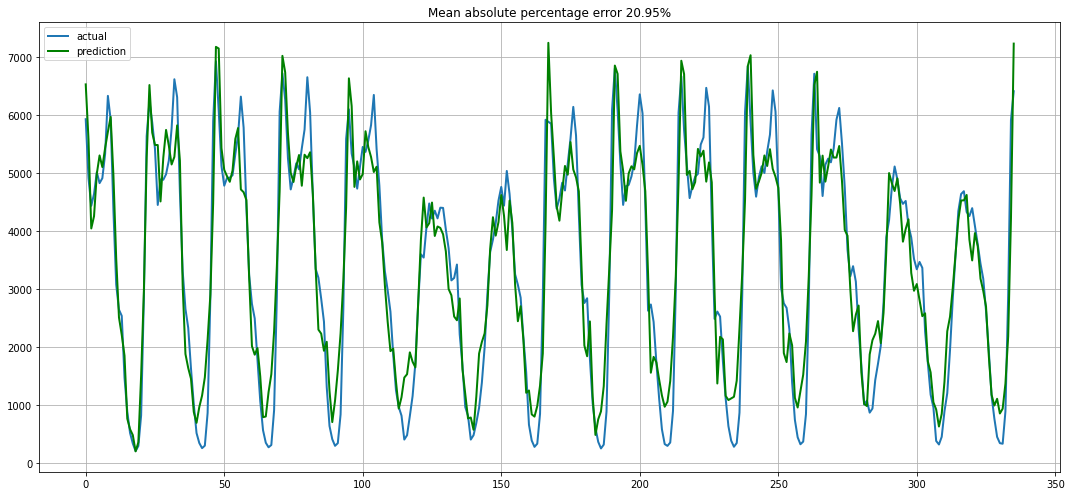

In [64]:
er = plotRecursivePrediction(lr, 'Linear Regression without time features', X_test, y_test,col_lag)
results.append(er)

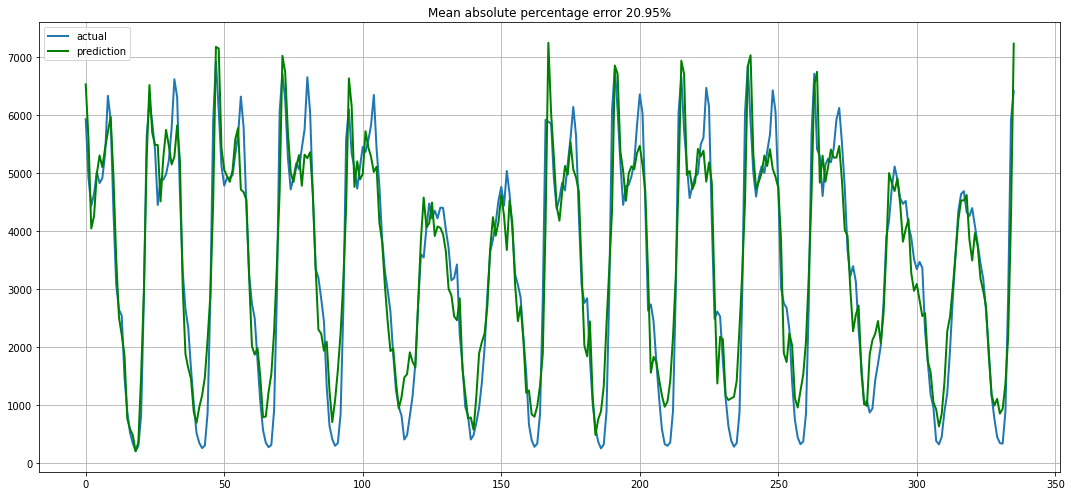

In [65]:
er = plotRecursivePrediction(ridge, 'Ridge without time features',X_test, y_test,col_lag)
results.append(er)

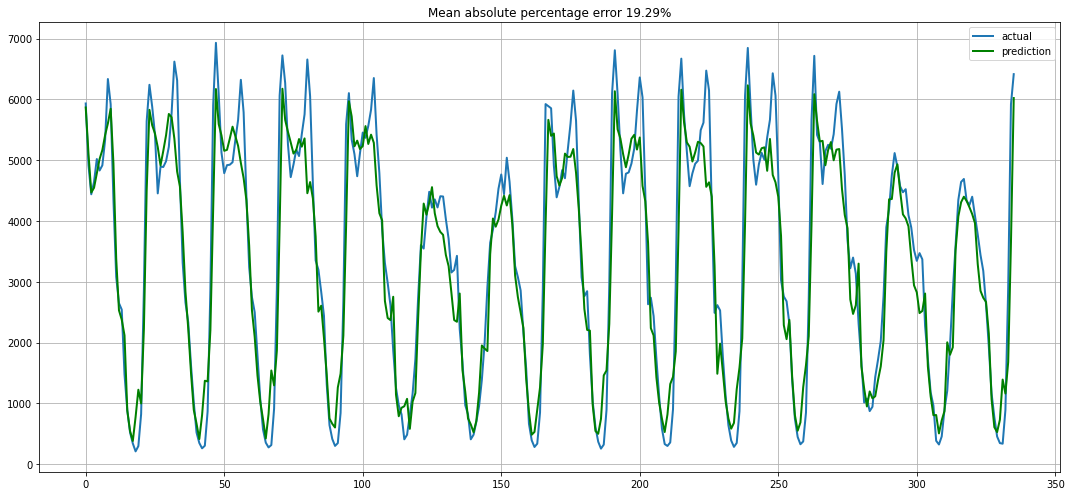

In [66]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

er = plotRecursivePrediction(gb,'Gradient Boosting without time features', X_test, y_test,col_lag)
results.append(er)

# 3 Модели с временными признаками

In [67]:
def create_time_features(data):
    data["hour"] = data.index.hour.values
    data['hour_cos'] = np.cos(2 * np.pi * data["hour"].values / 23)
    data['hour_sin'] = np.sin(2 * np.pi * data["hour"].values / 23)
    data["is_weekend"] = data.index.weekday.isin([5,6]).astype(int)
    return data


class MeanEncoder:
    def __init__(self, y_col, cat_feat):
        self.y_col = y_col
        self.cat_feat = cat_feat
        self.mean_codes = None
    
    def fit(self, data):
        cols = [self.y_col] + self.cat_feat
        self.mean_codes = data[cols].groupby(self.cat_feat).mean().to_dict()[self.y_col]
    
    def get_period_means(self, data):
        return data[self.cat_feat].apply(self._encode_with_mean, axis=1)
    
    def get_period_means_to_other(self, other_data):
        return other_data[self.cat_feat].apply(self._encode_with_mean, axis=1)
    
    def _encode_with_mean(self, row):
        key = tuple(row)
        val = self.mean_codes[key]
        return val


class LagEncoder:
    def __init__(self, start_lag, end_lag):
        self.start_lag = start_lag
        self.end_lag = end_lag
        self.lag_columns = []
        for i in range(self.start_lag, self.end_lag+1):
            col_name = "lag_{}".format(i)
            self.lag_columns.append(col_name)
    
    def get_lags(self, series):
        df_lags = pd.DataFrame(index=series.index)
        for i in range(self.start_lag, self.end_lag+1):
            col_name = self.lag_columns[i-1]
            df_lags[col_name] = series.shift(i)
        return df_lags

In [68]:
def prepare_data_from_1D_series(series, target='traffic_volume'):
    df_series = pd.DataFrame(series)
    df_series.index = pd.to_datetime(df_series.index)

    df_lags = lag_encoder.get_lags(series)
    data = pd.concat([df_series, df_lags], axis=1)
    data = create_time_features(data)
    mean_encoder.fit(data)
    data["mean_code"] = mean_encoder.get_period_means(data)

    data.dropna(inplace=True)
    data.loc[:,:] = scaler.fit_transform(data)
    
    feat_cols = data.columns.tolist()
    feat_cols.remove(target)
    
    Y = data[target]
    X = data[feat_cols]
    
    forecast_start_X = data.loc[data.index[-1], [target]+lag_encoder.lag_columns[:-1]]    
    forecast_start_X.index = lag_encoder.lag_columns
    
    return X, Y,  target, feat_cols, forecast_start_X

In [69]:
def create_forecast_timestamp(series, forecast_horizon):
    t2 = pd.to_datetime(series.index[-1])
    t1 = pd.to_datetime(series.index[-2])
    delta = t2 - t1
    t_index = [t2 + delta]
    for _ in range(forecast_horizon-1):
        t_index.append(t_index[-1] + delta)
    return t_index


def build_forecast_df(series,  target, feat_cols, forecast_start_X, forecast_horizon):
    t_index = create_forecast_timestamp(series, forecast_horizon=forecast_horizon)
    # print(t_index)
    forecast_df = pd.DataFrame(columns=[target]+feat_cols, index=t_index)

    forecast_df = create_time_features(forecast_df)
    forecast_df["mean_code"] = mean_encoder.get_period_means(forecast_df)
    
    forecast_df.iloc[:,:] = scaler.transform(forecast_df)

    forecast_df.loc[t_index[0], lag_encoder.lag_columns] = forecast_start_X.values
    return forecast_df


def recursive_predict(model, target,df_forecast):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index
    
    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove(target)
    
    for i in range(horizon):
        timestamp = t[i]
        next_x = model.predict(df_pred.loc[[timestamp], feat_cols])[0]
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)
    
    df_pred.loc[:, target] = forecast
    df_pred.loc[:,:] = scaler.inverse_transform(df_pred)
    return df_pred


def plotRecursivePrediction(y_test, y_forecast,model_name):
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(y_test.values, y_forecast.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    errors={model_name:{
        "Mean absolute percentage error":error,
        "Mean absolute error":mean_absolute_error(y_test.values, y_forecast.values),
        "Mean squared error":mean_squared_error(y_test.values,  y_forecast.values,squared=True),
        "Root mean squared error":mean_squared_error(y_test.values,  y_forecast.values,squared=False),
        "R2": r2_score(y_test.values,  y_forecast.values)
        }}
    return errors


def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [70]:
target='traffic_volume'
series_train, series_test = timeseries_train_test_split(short_data.iloc[:5000,1], test_size=0.3)

mean_encoder = MeanEncoder(y_col=target, cat_feat=["hour", "is_weekend"])
scaler = StandardScaler()
lag_encoder = LagEncoder(start_lag=1, end_lag=30)

In [71]:
X_train, y_train, target, feat_cols, forecast_start_X = prepare_data_from_1D_series(series_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

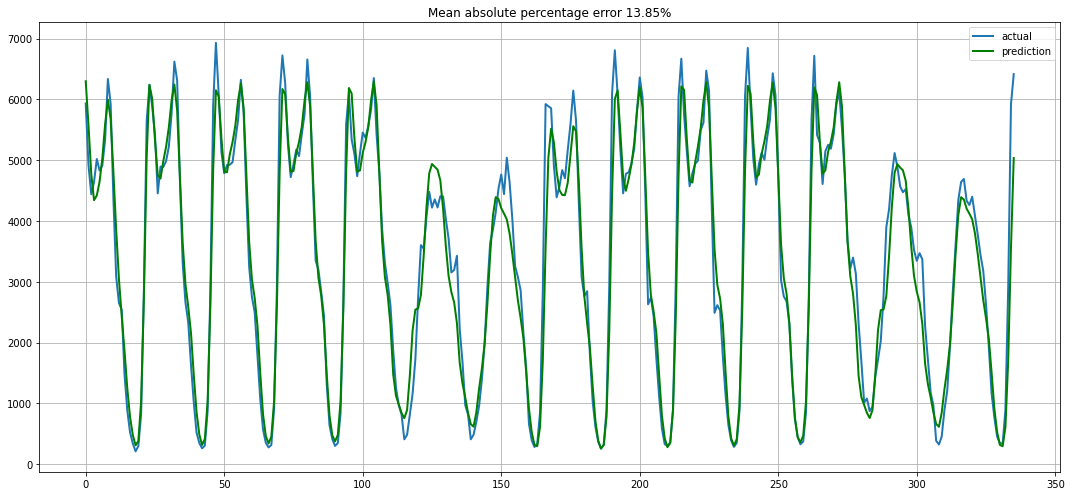

In [72]:
df_forecast = build_forecast_df(series_train, target,feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(lr, target, df_forecast)

er = plotRecursivePrediction(series_test, df_forecasted[target], "Linear Regression with time features")
results.append(er)

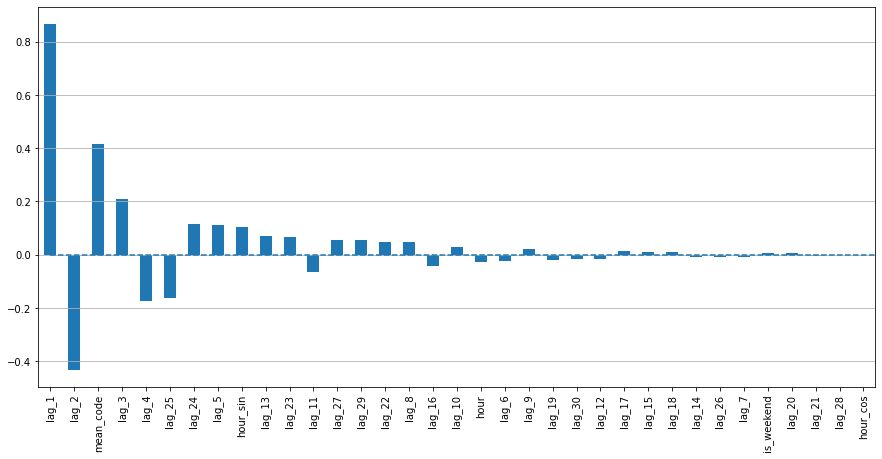

In [73]:
plotCoefficients(lr, X_train)

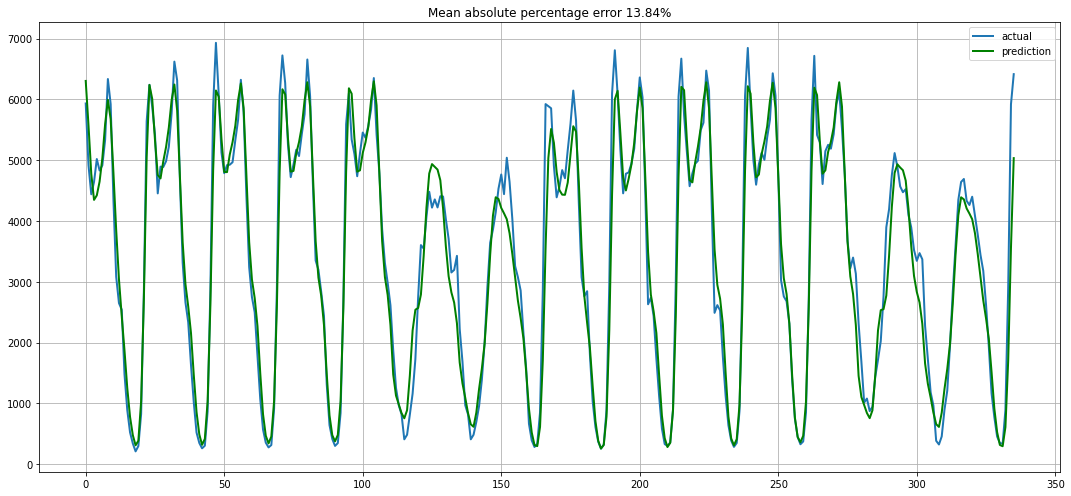

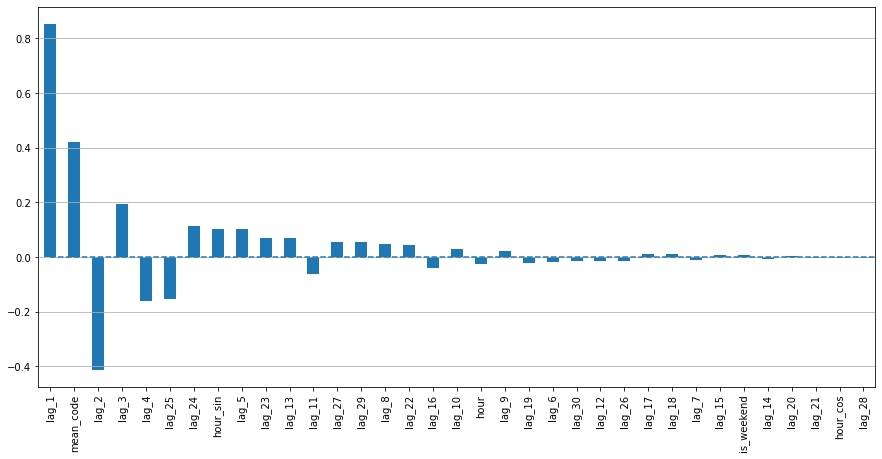

In [74]:
tscv = TimeSeriesSplit(n_splits=5)
ridge = RidgeCV(cv=tscv, alphas=np.linspace(0.1, 10, 100))
ridge.fit(X_train, y_train)

df_forecast = build_forecast_df(series_train, target, feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(ridge, target,df_forecast)

er = plotRecursivePrediction(series_test, df_forecasted[target], "Ridge with time features")
results.append(er)
plotCoefficients(ridge, X_train)

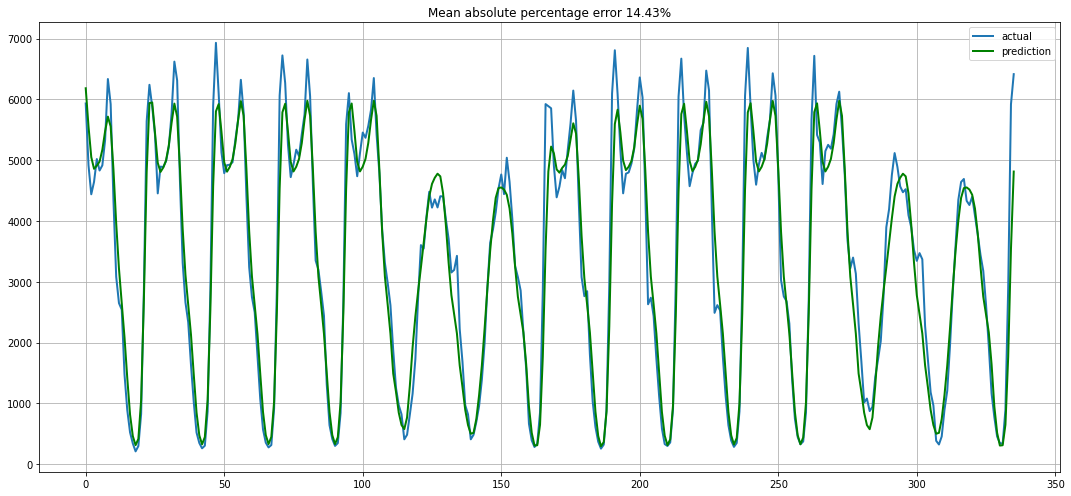

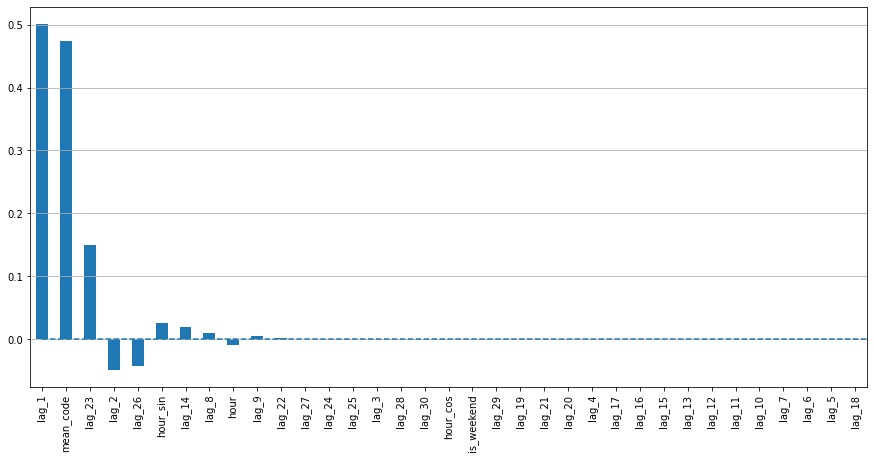

In [75]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

df_forecast = build_forecast_df(series_train, target, feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(lasso, target,df_forecast)

er = plotRecursivePrediction(series_test, df_forecasted[target],"Lasso with time features")
results.append(er)
plotCoefficients(lasso, X_train)

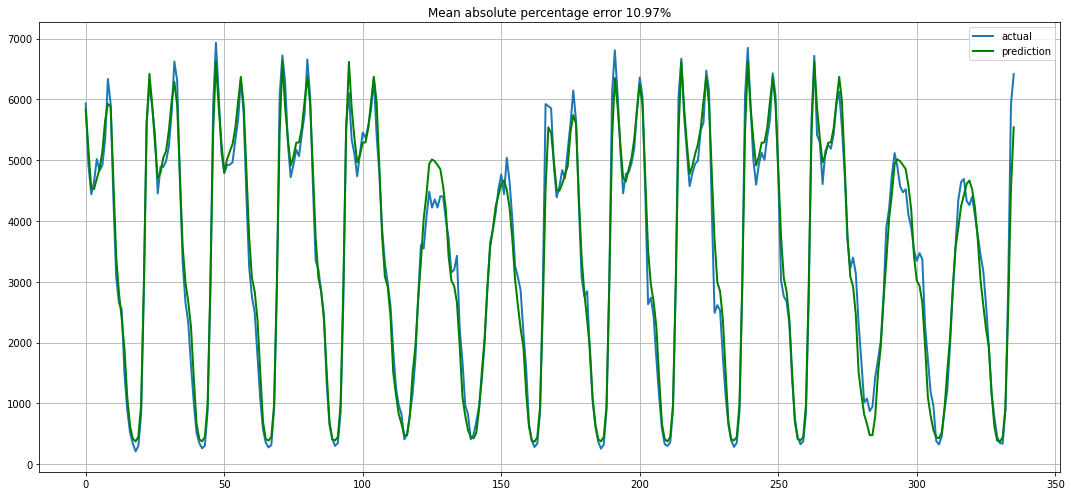

In [76]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

df_forecast = build_forecast_df(series_train, target,feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(gb, target,df_forecast)

er = plotRecursivePrediction(series_test, df_forecasted[target],"Gradient Boosting with time features")
results.append(er)

In [77]:
def get_base_line(y_test,y_train,target):
    if (len(y_train)<len(y_test)):
        print("This: len(y_train)<len(y_test) is wrong!!!")
        return -1
    df_test = pd.DataFrame(y_test)
    
    df_train = pd.DataFrame(y_train)
 
    df_test = create_time_features(df_test)
    df_train = create_time_features(df_train)
   
    mean_encoder.fit(df_train)
    df_test["mean_code"] = mean_encoder.get_period_means_to_other(df_test)

    MAPE = mean_absolute_percentage_error(df_test[target], df_test["mean_code"])
    errors={'Baseline':{
        "Mean absolute percentage error":MAPE,
        "Mean absolute error":mean_absolute_error(df_test[target], df_test["mean_code"]),
        "Mean squared error":mean_squared_error(df_test[target], df_test["mean_code"],squared=True),
        "Root mean squared error":mean_squared_error(df_test[target], df_test["mean_code"],squared=False),
        "R2": r2_score(df_test[target], df_test["mean_code"])
        }}
    return errors

In [78]:
baseline = get_base_line(series_test,series_train,target)
results.append(baseline)

In [79]:
print(baseline)

{'Baseline': {'Mean absolute percentage error': 11.373328542342353, 'Mean absolute error': 252.74330361298803, 'Mean squared error': 113973.82453593925, 'Root mean squared error': 337.6000955804652, 'R2': 0.971456599127243}}


# 4 Результаты

## 4.1 Сравнения моделей на тестовом наборе

In [80]:
otputdf = pd.DataFrame.from_dict(results[0], orient= 'index')
for item in results[1:]:
    otputdf = pd.concat([otputdf, pd.DataFrame.from_dict(item, orient= 'index')],axis=0)
otputdf = otputdf.drop('R2',axis=1)
otputdf.columns = ['MAPE','MAE','MSE','RMSE']

In [81]:
otputdf

,MAPE,MAE,MSE,RMSE
Cheating Linear Regression without time features,16.364850,278.261821,151378.157438,389.073460
Cheating Ridge without time features,16.335659,278.137629,151374.689200,389.069003
Linear Regression without time features,20.953404,500.439040,411529.620165,641.505744
Ridge without time features,20.951098,500.308660,411398.360612,641.403430
Gradient Boosting without time features,19.286905,465.370048,402839.758904,634.696588
Linear Regression with time features,13.852963,315.169514,200404.610488,447.665735
Ridge with time features,13.839497,314.842378,200009.265246,447.223954
Lasso with time features,14.427889,339.970139,238287.040879,488.146536
Gradient Boosting with time features,10.966772,235.225545,99727.818884,315.797117
Baseline,11.373329,252.743304,113973.824536,337.600096


## 4.2 Результаты лучшей модели в прогнозе на 2 неделю в перед на отложенной выборке

In [82]:
target='traffic_volume'
series_train, series_test = timeseries_train_test_split(short_data.iloc[5000:,1])
mean_encoder = MeanEncoder(y_col=target, cat_feat=["hour", "is_weekend"])
scaler = StandardScaler()
lag_encoder = LagEncoder(start_lag=1, end_lag=30)
X_train, y_train, target, feat_cols, forecast_start_X = prepare_data_from_1D_series(series_train)

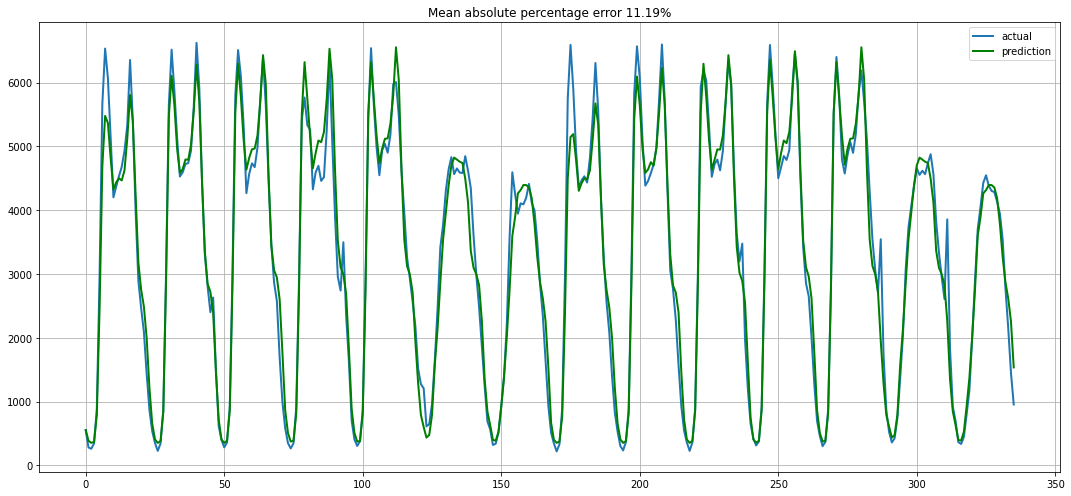

In [83]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

df_forecast = build_forecast_df(series_train, target,feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(gb, target,df_forecast)

er = plotRecursivePrediction(series_test, df_forecasted[target],"GB")

In [89]:
baseline = get_base_line(series_test,series_train,target)
compare = pd.concat([pd.DataFrame.from_dict(baseline, orient= 'index'), pd.DataFrame.from_dict(er, orient= 'index')],axis=0)
compare = compare.drop('R2',axis=1)
compare.head()

,Mean absolute percentage error,Mean absolute error,Mean squared error,Root mean squared error
Baseline,11.436027,261.235977,137221.658637,370.434419
GB,11.186817,240.653733,119315.763012,345.421139


# Заключение

Был рассмотрен набор данных, в котором оказались: 
- пропуски данных во времени разной длинны от 1 значения до 7386 значений подряд (в котором значения отсутствовали от 2014-08-08 02:00:00 до 2015-06-11 19:00:00),
- дублирующиеся значения признаков на одну и туже дату,
- обозначения признака "праздничный день" отмечалось не для каждого часа этого дня, а только в самом начале дня в 00-00-00.  


Результаты сравнения показали, что добавление временных признаков:
- час,
- день недели,
- синус, косинус от времени дня,

существенно снизили погрешности прогноза и тем самым, увеличили прогностические способности моделей. 

Выбранная лучшая модель показала незначительно лучший результат, чем baseline для данной задачи. 
